<a href="https://colab.research.google.com/github/arnaldojr/previsao-covid-19/blob/master/EP4_IME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prevendo estágio de contagio da Covid-19

## Antes de rodar o script certifique-se de ter ativado a GPU.
acesse: Runtime -> Change runtime type --> Hardware Accelerator: GPU

### Arnaldo Alves Viana Junior

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
#nao esquece das classicas
import numpy as np

In [74]:
df = pd.read_csv('/content/Covid_filtrada_1907.csv', encoding='windows-1250', sep=';')
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (128) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ID_Paciente,Leucócitos,Hemoglobina,Hematócrito,Plaquetas,Eritrócitos,VCM,RDW,Basófilos,Eosinófilos,Linfócitos,Monócitos,Neutrófilos,CHCM,HCM,Volume plaquetário médio,Proteína C-Reativa,Creatinina,Uréia,Cálculo p/afrodescendente CKD-EPI,Cálculo p/afrodescendente MDRD,Cálculo p/năo afrodescendente CKD-EPI,Cálculo p/năo afrodescendente MDRD,Potássio,Sódio,Magnésio,"Dimeros D, quant",Cálcio Ionizável,ALT (TGP),AST (TGO),Coronavírus (2019-nCoV),DHL,Fósforo,BE venoso,HCO3 venoso,pCO2 venoso,pH venoso,pO2 venoso,Sat O2 venoso,TTPA,...,Albumina,TSH,Triglicérides,Lipase,HDL-Colesterol,Colesterol total,CK-MB,VLDL-Colesterol,LDL Colesterol,"Dismorfismo, urina",Cálcio,25OH-Vitamina D Total,Vancomicina,Ácido Úrico,Hepar. Baixo Peso Mol Anti-Xa,"Hemocultura para fungos, por maldi-tof, vários materiais",Interleucina 6,Ferro,VHS,Promielócitos,Vitamina B-12,Proteínas,Anti-HBs,Cultura Quantitativa,Anti-HCV,Ferro Grau Saturaçăo,Siderofilina,Ácido fólico,AgHBs,"Dengue, antígeno NS1",Clostridium difficile,Hormônio Tiroestimulante,"Cultura Automatizada, 3Ş Amostra",Coronavírus (2019-nCoV).1,"Covid 19, Anticorpos IgA","Covid 19, Anticorpos IgA, índice","Covid 19,Antic IgM/IgG,teste rápido-Interpret","Y-Covid 19, por PCR","Y-Covid 19, Anticorpos IgG","Y-Covid 19, Anticorpos IgM"
0,00177290279939FB33386B29198C450E11/jun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
1,003051C9B19101D1C10C5DC65438401701/jun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
2,003051C9B19101D1C10C5DC65438401704/jun,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
3,003051C9B19101D1C10C5DC65438401712/jun,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0
4,003F1F4C194763E4A00FD809AF5FA6AA01/abr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
df = df.replace({np.nan: -1})
df = df.drop(columns=['ID_Paciente'])
df.head()

,Leucócitos,Hemoglobina,Hematócrito,Plaquetas,Eritrócitos,VCM,RDW,Basófilos,Eosinófilos,Linfócitos,Monócitos,Neutrófilos,CHCM,HCM,Volume plaquetário médio,Proteína C-Reativa,Creatinina,Uréia,Cálculo p/afrodescendente CKD-EPI,Cálculo p/afrodescendente MDRD,Cálculo p/năo afrodescendente CKD-EPI,Cálculo p/năo afrodescendente MDRD,Potássio,Sódio,Magnésio,"Dimeros D, quant",Cálcio Ionizável,ALT (TGP),AST (TGO),Coronavírus (2019-nCoV),DHL,Fósforo,BE venoso,HCO3 venoso,pCO2 venoso,pH venoso,pO2 venoso,Sat O2 venoso,TTPA,TTPA - Paciente/Normal,...,Albumina,TSH,Triglicérides,Lipase,HDL-Colesterol,Colesterol total,CK-MB,VLDL-Colesterol,LDL Colesterol,"Dismorfismo, urina",Cálcio,25OH-Vitamina D Total,Vancomicina,Ácido Úrico,Hepar. Baixo Peso Mol Anti-Xa,"Hemocultura para fungos, por maldi-tof, vários materiais",Interleucina 6,Ferro,VHS,Promielócitos,Vitamina B-12,Proteínas,Anti-HBs,Cultura Quantitativa,Anti-HCV,Ferro Grau Saturaçăo,Siderofilina,Ácido fólico,AgHBs,"Dengue, antígeno NS1",Clostridium difficile,Hormônio Tiroestimulante,"Cultura Automatizada, 3Ş Amostra",Coronavírus (2019-nCoV).1,"Covid 19, Anticorpos IgA","Covid 19, Anticorpos IgA, índice","Covid 19,Antic IgM/IgG,teste rápido-Interpret","Y-Covid 19, por PCR","Y-Covid 19, Anticorpos IgG","Y-Covid 19, Anticorpos IgM"
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,-1.0,-1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,-1.0,-1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,-1.0,-1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0


In [76]:
df.shape

(10142, 130)

# fazendo o tratamento do dataset customizado

In [77]:
import torch 
from torch import nn, optim

from torch.utils.data import DataLoader
from torch.utils.data import Dataset


#nao esquece das classicas
import numpy as np


# Dicionario de hiperparametros
args = {
    'batch_size': 20,
    'num_workers': 4,
    'hidden_size': 128,
    'lr': 1e-4,
    'weight_decay': 5e-4,
    'num_epochs': 30
}

# testa GPU
if torch.cuda.is_available():
  args['device'] = torch.device('cuda')
else:
  args['device'] = torch.device('cpu')
print(args['device'])


cuda


In [78]:
#separação de treino e teste

torch.manual_seed(1)
indices = torch.randperm(len(df)).tolist()

train_size = int(0.8*len(df))
df_train = df.iloc[indices[:train_size]]
df_test = df.iloc[indices[train_size:]]

print(len(df_train),len(df_test))
display(df_test.head())

df_train.to_csv('covid_train.csv', index=False)
df_test.to_csv('covid_test.csv', index=False)

8113 2029


,Leucócitos,Hemoglobina,Hematócrito,Plaquetas,Eritrócitos,VCM,RDW,Basófilos,Eosinófilos,Linfócitos,Monócitos,Neutrófilos,CHCM,HCM,Volume plaquetário médio,Proteína C-Reativa,Creatinina,Uréia,Cálculo p/afrodescendente CKD-EPI,Cálculo p/afrodescendente MDRD,Cálculo p/năo afrodescendente CKD-EPI,Cálculo p/năo afrodescendente MDRD,Potássio,Sódio,Magnésio,"Dimeros D, quant",Cálcio Ionizável,ALT (TGP),AST (TGO),Coronavírus (2019-nCoV),DHL,Fósforo,BE venoso,HCO3 venoso,pCO2 venoso,pH venoso,pO2 venoso,Sat O2 venoso,TTPA,TTPA - Paciente/Normal,...,Albumina,TSH,Triglicérides,Lipase,HDL-Colesterol,Colesterol total,CK-MB,VLDL-Colesterol,LDL Colesterol,"Dismorfismo, urina",Cálcio,25OH-Vitamina D Total,Vancomicina,Ácido Úrico,Hepar. Baixo Peso Mol Anti-Xa,"Hemocultura para fungos, por maldi-tof, vários materiais",Interleucina 6,Ferro,VHS,Promielócitos,Vitamina B-12,Proteínas,Anti-HBs,Cultura Quantitativa,Anti-HCV,Ferro Grau Saturaçăo,Siderofilina,Ácido fólico,AgHBs,"Dengue, antígeno NS1",Clostridium difficile,Hormônio Tiroestimulante,"Cultura Automatizada, 3Ş Amostra",Coronavírus (2019-nCoV).1,"Covid 19, Anticorpos IgA","Covid 19, Anticorpos IgA, índice","Covid 19,Antic IgM/IgG,teste rápido-Interpret","Y-Covid 19, por PCR","Y-Covid 19, Anticorpos IgG","Y-Covid 19, Anticorpos IgM"
5888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1,1.0,1.0
3852,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,1,0.0,-1.0
2908,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,0.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,0.0,0.0
4972,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,-1.0,-1.0
1210,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0


In [79]:
!ls
print(df_train.shape)
print(df_test.shape)


Covid_filtrada_1907.csv  covid_test.csv  covid_train.csv  sample_data
(8113, 130)
(2029, 130)


In [80]:
# Criar a classe Dataset

class CovidSet(Dataset):
  def __init__(self, csv_path):
    self.dados = pd.read_csv(csv_path).to_numpy()

  def __getitem__(self, idx):

    sample = self.dados[idx][:65] # tamanho da entrada, quantidade colunas
    label = self.dados[idx][129:130] # tamanho da saida, quantidade de coluna

    #Converte para tensor
    sample = torch.from_numpy(sample.astype(np.float32))
    np.nan_to_num(sample, copy=False)
    label = torch.from_numpy(label.astype(np.float32))
    #np.nan_to_num(label, copy=False)
    return sample, label

  
  def __len__(self):
    
    return len(self.dados)

In [81]:
train_set = CovidSet('covid_train.csv')
test_set = CovidSet('covid_test.csv')


dado, rotulo = train_set[13]
print(rotulo, dado)

tensor([-1.]) tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., -1.,  0., -1., -1.,
        -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1.,  0., -1., -1., -1., -1.,  1., -1., -1.])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (127) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [82]:
train_loader = DataLoader(train_set,
                          batch_size=args['batch_size'],
                          shuffle=True,
                          num_workers=args['num_workers'])

test_loader = DataLoader(test_set,
                          batch_size=args['batch_size'],
                          shuffle=True,
                          num_workers=args['num_workers'])

In [83]:
for batch in train_loader:
  dado, rotulo = batch
  print(dado.size(), rotulo.size())

  break

torch.Size([20, 65]) torch.Size([20, 1])


In [84]:
#Implementando ao MLP
#pega o ultima feito e altera

# Implementar o MLP

class MLP(nn.Module):

  def __init__(self, input_size, hidden_size, output_size): 
    super(MLP, self).__init__()
    
    self.features = nn.Sequential(
                    nn.Linear(input_size,hidden_size),
                    nn.ReLU(),
                    nn.Linear(hidden_size, hidden_size),
                    nn.ReLU()
                    )
    self.out = nn.Linear(hidden_size, output_size)
    #self.softmax = nn.Softmax() nao faz sentido usar softmax

  def forward(self, X):
    
    feature = self.features(X)
    output = self.out(feature)

    return output

input_size = len(train_set[0][0]) #tamanho da entrada
hidden_size = args['hidden_size'] # camada intermediaria
output_size = 1 # camada de saida, é o que será predito.

net = MLP(input_size, hidden_size, output_size).to(args['device'])

In [85]:
#criterio de perda
criterion = nn.L1Loss().to(args['device'])
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [86]:
#fluxo de treinamento
def train(train_loader,net, epoch):
  net.train() # garante modo de treinamento 
  epoch_loss = []
  for batch in train_loader:
    
    dado, rotulo = batch

    # Cast na GPU
    dado   = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])

    # Forward 
    pred = net(dado)
    loss = criterion(pred, rotulo)
    epoch_loss.append(loss.cpu().data)

    # Backward
    loss.backward()
    optimizer.step()

  epoch_loss = np.asarray(epoch_loss)
  print("--------treinamento-----")
  print("Epoca %d, Loss: %.4f +\- %.4f" % (epoch, epoch_loss.mean(), epoch_loss.std()))
  return epoch_loss.mean()

In [87]:
#fluxo de validação / teste
def test(test_loader,net, epoch):
  #tem que fazer isso para rodar os testes
  net.eval()
  with torch.no_grad(): 
    #o resto é igual
    epoch_loss = []
    for batch in test_loader:
      
      dado, rotulo = batch

      # Cast na GPU
      dado   = dado.to(args['device'])
      rotulo = rotulo.to(args['device'])

      # Forward 
      pred = net(dado)
      loss = criterion(pred, rotulo)
      epoch_loss.append(loss.cpu().data)

    epoch_loss = np.asarray(epoch_loss)
    print("--------validação-----")
    print("Epoca %d, Loss: %.4f +\- %.4f" % (epoch, epoch_loss.mean(), epoch_loss.std()))
    return epoch_loss.mean()

In [88]:
train_losses, test_losses = [], []
for epoch in range(args['num_epochs']):
  train_losses.append(train(train_loader,net,epoch))
  test_losses.append(test(test_loader,net,epoch))
  print("--------------------")


--------treinamento-----
Epoca 0, Loss: 0.4202 +\- 0.1663
--------validação-----
Epoca 0, Loss: 0.4352 +\- 0.0451
--------------------
--------treinamento-----
Epoca 1, Loss: 0.3816 +\- 0.1186
--------validação-----
Epoca 1, Loss: 0.4101 +\- 0.0552
--------------------
--------treinamento-----
Epoca 2, Loss: 0.3416 +\- 0.1108
--------validação-----
Epoca 2, Loss: 0.3141 +\- 0.0636
--------------------
--------treinamento-----
Epoca 3, Loss: 0.3241 +\- 0.1051
--------validação-----
Epoca 3, Loss: 0.3421 +\- 0.0695
--------------------
--------treinamento-----
Epoca 4, Loss: 0.2822 +\- 0.0901
--------validação-----
Epoca 4, Loss: 0.2035 +\- 0.0738
--------------------
--------treinamento-----
Epoca 5, Loss: 0.2603 +\- 0.0788
--------validação-----
Epoca 5, Loss: 0.2313 +\- 0.0622
--------------------
--------treinamento-----
Epoca 6, Loss: 0.2482 +\- 0.0923
--------validação-----
Epoca 6, Loss: 0.3331 +\- 0.0494
--------------------
--------treinamento-----
Epoca 7, Loss: 0.2360 +\- 0.09

In [89]:
Xtest = torch.stack([tup[0] for tup in test_set])
Xtest = Xtest.to(args['device'])

ytest = torch.stack([tup[1] for tup in test_set])
ypred = net(Xtest).cpu().data

data = torch.cat((ytest, ypred), axis=1)

df_results = pd.DataFrame(data, columns=['ypred', 'ytest'])
df_results.head(20)

,ypred,ytest
0,tensor(1.),tensor(-0.8977)
1,tensor(-1.),tensor(-0.8705)
2,tensor(0.),tensor(-0.9267)
3,tensor(-1.),tensor(-1.0754)
4,tensor(-1.),tensor(-0.9663)
5,tensor(-1.),tensor(-0.9608)
6,tensor(-1.),tensor(-0.9663)
7,tensor(-1.),tensor(-0.8830)
8,tensor(-1.),tensor(-0.9608)
9,tensor(-1.),tensor(-0.9583)


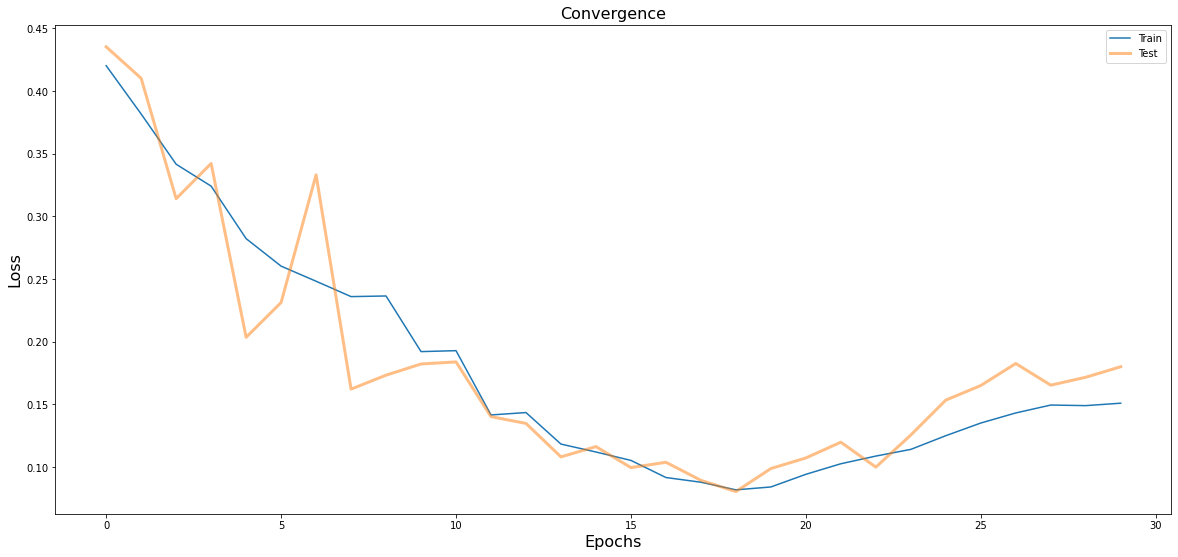

In [90]:
plt.figure(figsize=(20, 9))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test', linewidth=3, alpha=0.5)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Convergence', fontsize=16)
plt.legend()
plt.show()

In [91]:
print(train_losses)

[0.42015857, 0.3816057, 0.3415618, 0.3240863, 0.282213, 0.260268, 0.2482246, 0.23595944, 0.23646712, 0.19209047, 0.19284366, 0.14156564, 0.14348154, 0.1183267, 0.11201298, 0.10530735, 0.09165872, 0.08790229, 0.081828244, 0.08412389, 0.094215356, 0.10263965, 0.108761884, 0.11410177, 0.12501512, 0.13512346, 0.14316572, 0.14946328, 0.14900853, 0.15094376]
